<a href="https://colab.research.google.com/github/tavishcode/fyp/blob/master/rescale_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Activation, CuDNNGRU, GRU, Dense
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler
from collections import OrderedDict, defaultdict
from google.colab import drive
from scipy.optimize import curve_fit
drive.mount('/content/drive')
plt.rcParams['figure.figsize'] = [10, 8]

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('drive/My Drive/train_2.csv')
df.drop('Page', axis=1, inplace=True)
df.fillna(0, inplace = True)
df.shape

(145063, 803)

### Total Requests for each content



In [0]:
sums = df.sum(axis=1).sort_values(ascending=False)
sums = sums.values
sums = sums[np.nonzero(sums)]
probs = sums/sum(sums)

In [0]:
arr = df.values

Text(0.5, 1.0, 'Probability Distribution')

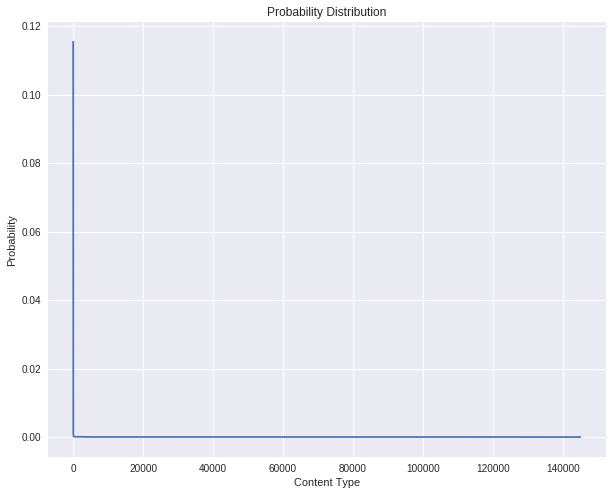

In [0]:
plt.plot(range(1, len(probs)+1), probs)
plt.xlabel('Content Type')
plt.ylabel('Probability')
plt.title('Probability Distribution')

Text(0.5, 1.0, 'log-log Probability Distribution')

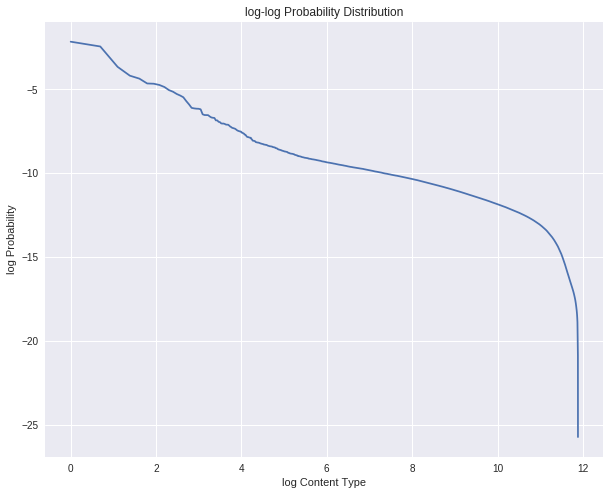

In [0]:
plt.plot(np.log(range(1, len(probs)+1)), np.log(probs)) #log-log plot
plt.xlabel('log Content Type')
plt.ylabel('log Probability')
plt.title('log-log Probability Distribution')

In [0]:
# fitting a zipf to the data
def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(probs)+1)])

x_data = [i for i in range(1,len(probs)+1)]
y_data = probs

popt, pcov = curve_fit(zipf, x_data, y_data)
popt

array([1.0770667])

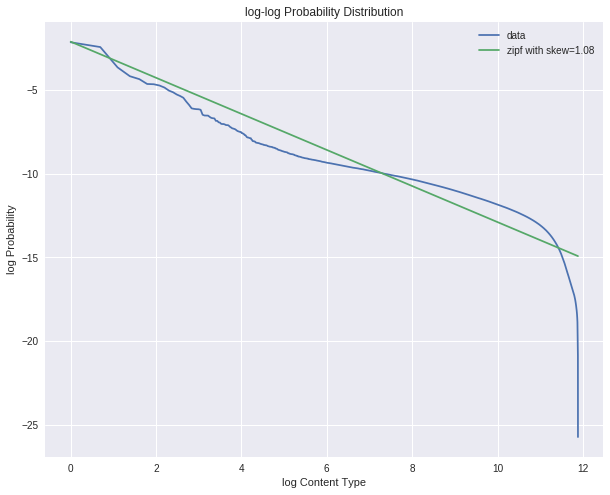

In [0]:
norm = sum([i**-popt[0] for i in range(1,len(probs)+1)])
plt.plot(np.log(range(1, len(probs)+1)), np.log(probs)) #log-log plot
plt.plot(np.log(x_data), np.log([i**-popt[0]/norm for i in x_data]))
plt.xlabel('log Content Type')
plt.ylabel('log Probability')
plt.title('log-log Probability Distribution')
plt.legend(['data', 'zipf with skew=1.08'])

### Attempt # 0 - Sorted Slice

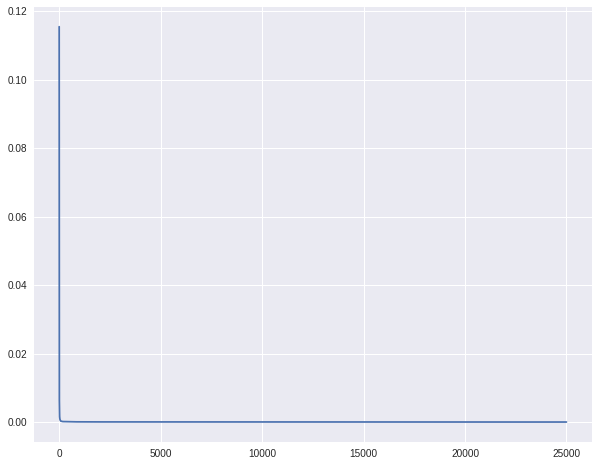

In [0]:
plt.plot(range(1, 25001), probs[:25000])

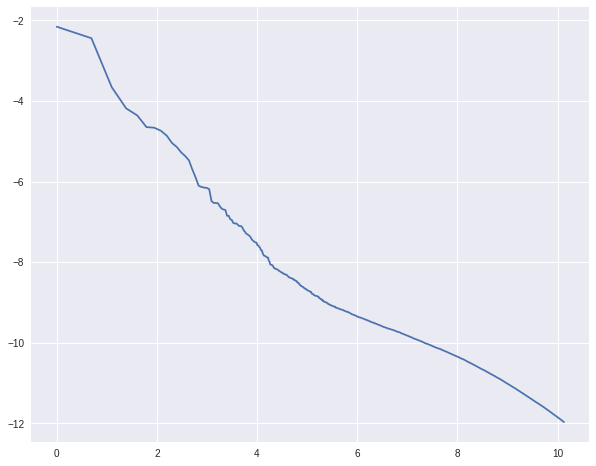

In [0]:
plt.plot(np.log(range(1, 25001)), np.log(probs[:25000]))

In [0]:
# using scipy curve fit

from scipy.optimize import curve_fit

def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(probs[:25000])+1)])

x_data = [i for i in range(1,len(probs[:25000])+1)]
y_data = probs[:25000]

popt, pcov = curve_fit(zipf, x_data, y_data)
popt

array([1.05314092])

### Attempt #1 - Scaling thorugh daily probabilities


In [0]:
num_reqs_per_day = 50000
rescaled_arr = np.zeros(arr.shape)
for i in range(arr.shape[1]):
  daily_reqs = arr[:,i]
  norm_reqs = daily_reqs/sum(daily_reqs)
  rescaled_daily_reqs = np.round(num_reqs_per_day*norm_reqs)
  rescaled_arr[:,i] = rescaled_daily_reqs

In [0]:
sums1 = np.sort(np.sum(rescaled_arr, axis=1))[::-1]
sums1 = sums1[np.nonzero(sums1)]
probs1 = sums1/sum(sums1)

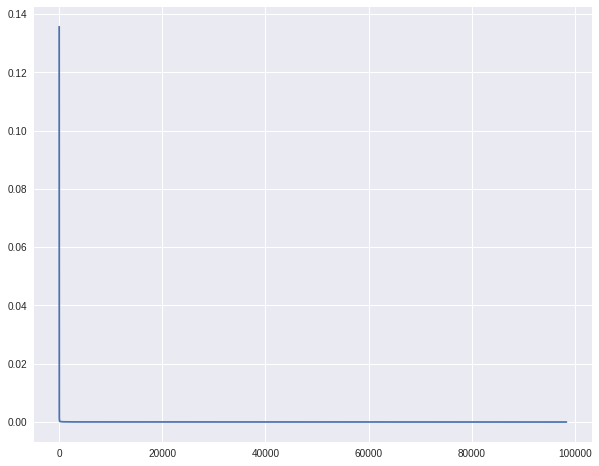

In [0]:
plt.plot(range(1, len(probs1)+1), probs1)

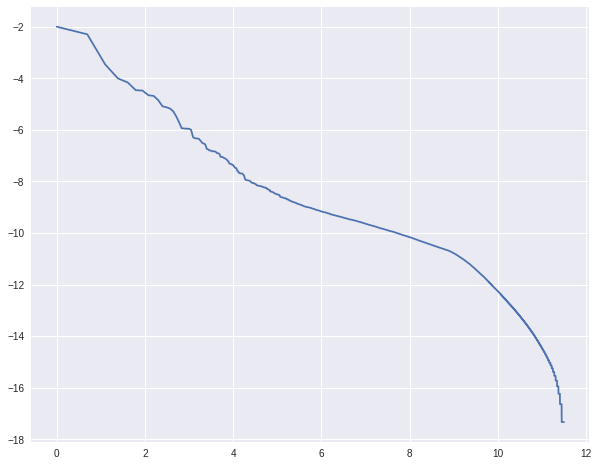

In [0]:
plt.plot(np.log(range(1,len(probs1)+1)), np.log(probs1))

In [0]:
# using scipy curve fit

from scipy.optimize import curve_fit

def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(probs1)+1)])

x_data = [i for i in range(1,len(probs1)+1)]
y_data = probs1

popt, pcov = curve_fit(zipf, x_data, y_data)
popt

array([1.11285438])

### Attempt # 2 - Scaling through exponential bins

In [0]:
# exp bins
r = 1.0001
probs2 = []
start = 0
exp = 0
size = int(r**exp)
exp_intervals = []
while start < len(probs):
  exp_intervals.append((start, start+size))
  probs2.append(sum(probs[start:start+size]))
  start = start+size
  exp += 1
  size = int(r**exp)

In [0]:
len(exp_intervals)

28237

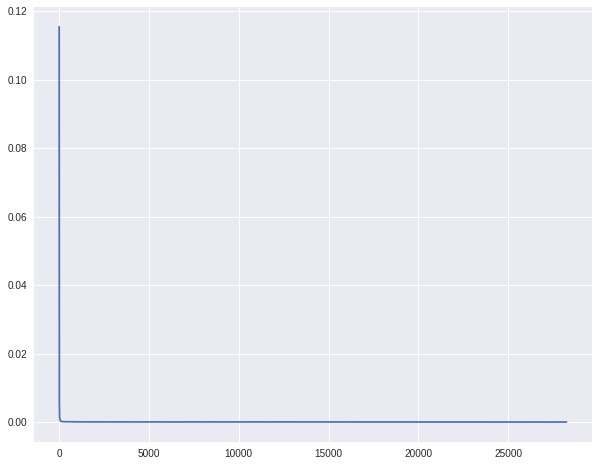

In [0]:
plt.plot(range(1, len(probs2)+1), probs2)

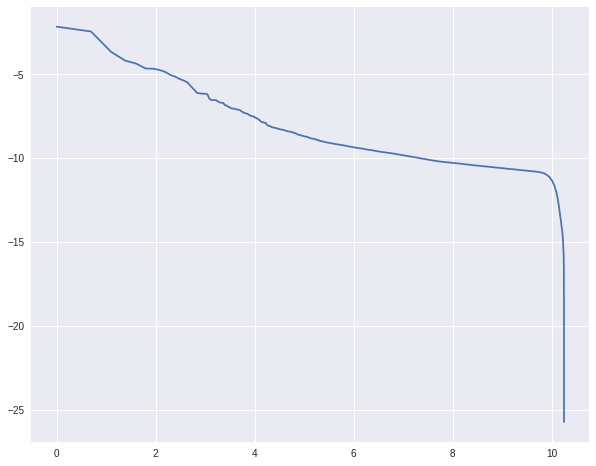

In [0]:
plt.plot(np.log(range(1, len(probs2)+1)), np.sort(np.log(probs2))[::-1])

In [0]:
# using scipy curve fit

from scipy.optimize import curve_fit

def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(probs2)+1)])

x_data = [i for i in range(1,len(probs2)+1)]
y_data = np.sort(probs2)[::-1]

popt, pcov = curve_fit(zipf, x_data, y_data)
popt

array([1.05517017])

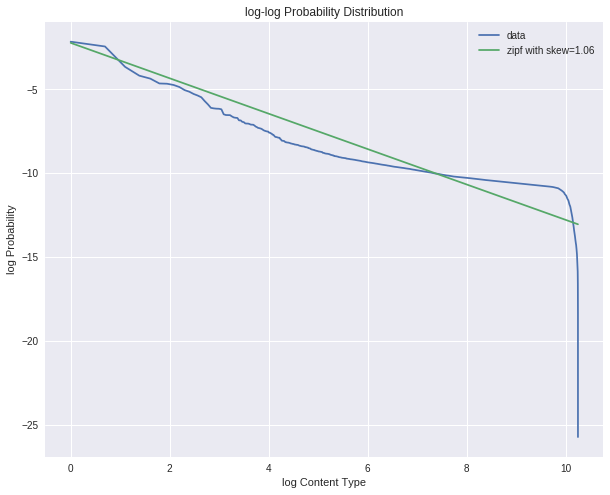

In [0]:
norm = sum([i**-popt[0] for i in range(1,len(probs)+1)])
plt.plot(np.log(range(1, len(probs2)+1)), np.log(np.sort(probs2)[::-1])) #log-log plot
plt.plot(np.log([i for i in range(1,len(probs2)+1)]), np.log([i**-popt[0]/norm for i in range(1,len(probs2)+1)]))
plt.xlabel('log Content Type')
plt.ylabel('log Probability')
plt.title('log-log Probability Distribution')
plt.legend(['data', 'zipf with skew=1.06'])

### Attempt # 3 - Linear Binning

In [0]:
probs3 = []
start = 0
size = 5
while start < len(probs):
  probs3.append(sum(probs[start:start+size]))
  start = start+size

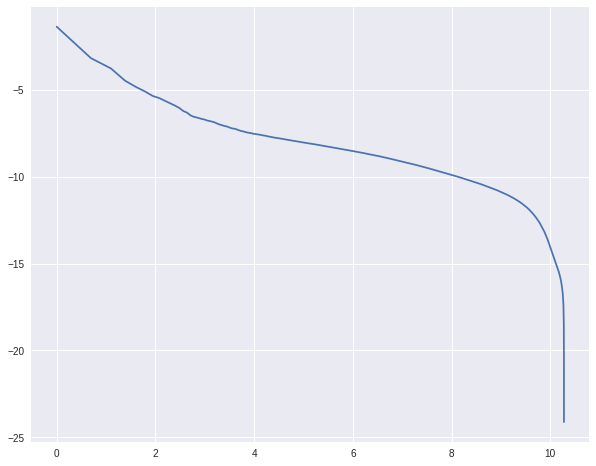

In [0]:
plt.plot(np.log(range(1, len(probs3)+1)), np.sort(np.log(probs3))[::-1])

In [0]:
# using scipy curve fit

from scipy.optimize import curve_fit

def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(probs3)+1)])

x_data = [i for i in range(1,len(probs3)+1)]
y_data = np.sort(probs3)[::-1]

popt, pcov = curve_fit(zipf, x_data, y_data)
popt

array([1.24176933])

### Attempt 5 - Random Sampling


In [0]:
rand_arr = np.copy(arr)
np.random.shuffle(rand_arr)
rand_arr = rand_arr[:50000,:]
r_sums = np.sort(np.sum(rand_arr, axis=1))[::-1]
r_sums = r_sums[np.nonzero(r_sums)]
r_probs = r_sums/sum(r_sums)

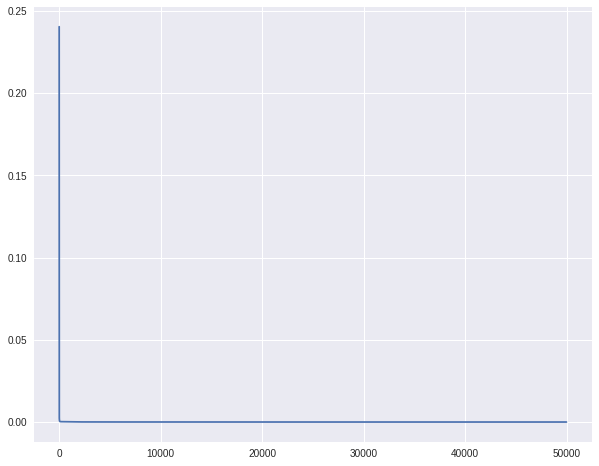

In [0]:
plt.plot(range(1, len(r_probs)+1), r_probs)

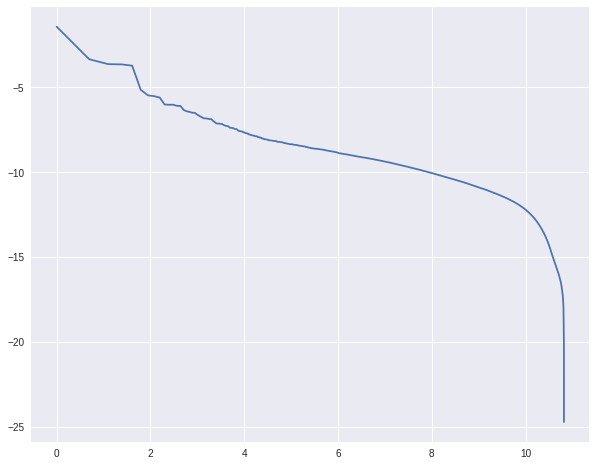

In [0]:
plt.plot(np.log(range(1, len(r_probs)+1)), np.log(r_probs))

In [0]:
# using scipy curve fit

from scipy.optimize import curve_fit

def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(r_probs)+1)])

x_data = [i for i in range(1,len(r_probs)+1)]
y_data = r_probs

popt, pcov = curve_fit(zipf, x_data, y_data)
popt

array([1.22232605])

### Making new dataset through exponential binning

In [0]:
arr = arr[np.sum(arr, axis=1).argsort()[::-1]]
arr = arr[~np.all(arr == 0, axis=1)]
np.sum(arr,axis=1)/np.sum(np.sum(arr, axis=1))

array([1.15451432e-01, 8.67440506e-02, 2.57730839e-02, ...,
       6.71375339e-12, 6.71375339e-12, 6.71375339e-12])

In [0]:
rescaled_ds = np.zeros((len(exp_intervals), df.shape[1]))
for ix, interval in enumerate(exp_intervals):
  visits = np.sum(arr[interval[0]:interval[1],:], axis=0)
  rescaled_ds[ix,:] = visits
rescaled_ds.shape

(28237, 803)

In [0]:
# further downsampling of exponential bins using daily probabilities
num_request_per_day = 50000
for i in range(rescaled_train.shape[1]):
  sum_daily_reqs = np.sum(rescaled_ds[:, i])
  rescaled_ds[:, i] = np.round(rescaled_ds[:, i]/sum_daily_reqs * num_request_per_day)
rescaled_ds.shape

(28237, 803)

In [0]:
# remove bins with a total of 0 requests throughout the 100 days
req_sums = np.sum(rescaled_ds, axis=1)
rescaled_ds = rescaled_ds[req_sums.nonzero()]
rescaled_ds.shape

(27222, 803)

In [0]:
np.save('rescaled_dataset.npy', rescaled_ds)

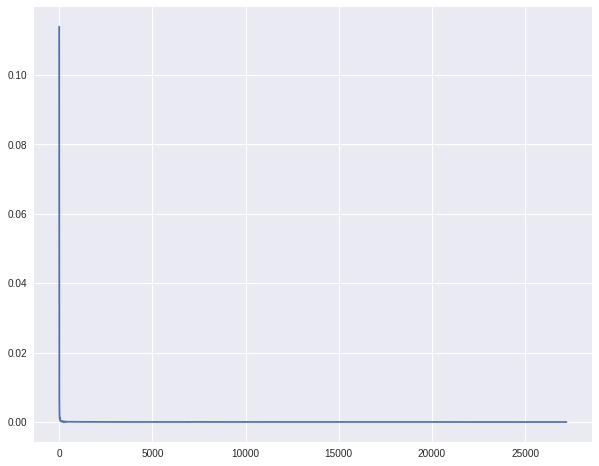

In [0]:
# plot frequencies
rescaled_sums = np.sum(rescaled_ds, axis=1)
rescaled_probs = rescaled_sums/sum(rescaled_sums)
plt.plot([i for i in range(1,len(rescaled_probs)+1)], rescaled_probs)

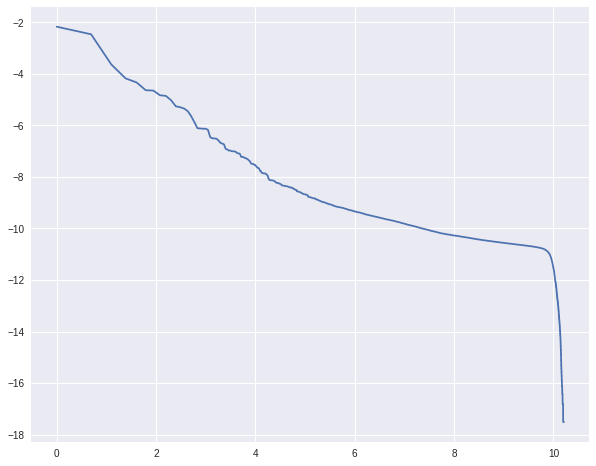

In [0]:
plt.plot(np.log([i for i in range(1,len(rescaled_probs)+1)]), np.sort(np.log(rescaled_probs))[::-1])

In [0]:
# using scipy curve fit


def zipf(x, s):
  return x**-s/sum([i**-s for i in range(1,len(rescaled_probs)+1)])

x_data = [i for i in range(1,len(rescaled_probs)+1)]
y_data = np.sort(rescaled_probs)[::-1]

popt, pcov = curve_fit(zipf, x_data, y_data)
popt

array([1.05118519])

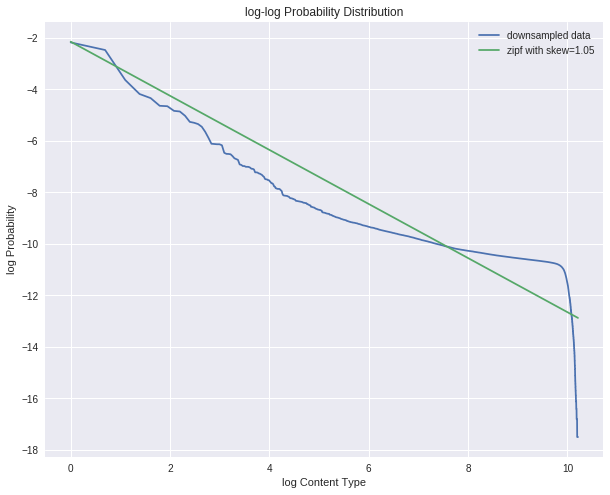

In [0]:
norm = sum([i**-popt[0] for i in range(1,len(rescaled_probs)+1)])
plt.plot(np.log([i for i in range(1,len(rescaled_probs)+1)]), np.sort(np.log(rescaled_probs))[::-1])
plt.plot(np.log([i for i in range(1,len(rescaled_probs)+1)]), np.log([i**-popt[0]/norm for i in range(1,len(rescaled_probs)+1)]))
plt.xlabel('log Content Type')
plt.ylabel('log Probability')
plt.title('log-log Probability Distribution')
plt.legend(['downsampled data', 'zipf with skew=1.05'])